In [75]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

%matplotlib inline

To keep everything clear and not to recompute things again and again I decided to use library for building pipelines [Luigi](http://luigi.readthedocs.io/en/stable/index.html), because of that all the intermediate results were saved and scripts have clear structure.

## First Task
Pipeline: <img src="images/pipeline1.png">

#### Simple statistics
To gather stats I am using dicts, they are handy and fast (hash table as base). For determining part of speech for words nltk.pos_tag was used.

In [76]:
with open("first_task/simple_stats.pickle", "r") as f:
    simple_stats = pickle.load(f)

In [77]:
def process_dict(d, key):
    print "----------- top %s -----------" %key
    temp = sorted(d[key].items(), key=lambda x: -x[1])[: 10]
    for l, n in temp:
        print "%60s: %d" %(l, n)
        
    return temp

In [78]:
print "Number of countries is", len(simple_stats["countries"])
print "Number of languages is", len(simple_stats["languages"])
print "Number of journals is", len(simple_stats["journals"])

Number of countries is 34
Number of languages is 6
Number of journals is 611


In [79]:
srt_countries = process_dict(simple_stats, "countries")

----------- top countries -----------
                                               united states: 1744
                                                     england: 619
                                                      canada: 39
                                                     germany: 31
                                                     ireland: 26
                                                 netherlands: 26
                                                     denmark: 22
                                                      norway: 16
                                                 switzerland: 16
                                                       italy: 14


In [49]:
_ = process_dict(simple_stats, "languages")

----------- top languages -----------
                                                         eng: 2645
                                                         spa: 3
                                                         dut: 2
                                                         fre: 1
                                                         chi: 1
                                                         dan: 1


In [50]:
srt_journals = process_dict(simple_stats, "journals")

----------- top journals -----------
            cochrane database of systematic reviews (online): 165
      jama : the journal of the american medical association: 132
                         the new england journal of medicine: 122
                                                      lancet: 81
                                                  pediatrics: 66
                                 bmj (clinical research ed.): 63
                                 annals of internal medicine: 61
                               archives of internal medicine: 46
                                                 circulation: 38
               american journal of obstetrics and gynecology: 36


In [51]:
_ = process_dict(simple_stats["pos"], "adjectives")

----------- top adjectives -----------
                                                     patient: 2205
                                                      clinic: 1614
                                                         low: 949
                                                       studi: 923
                                                        high: 897
                                                     subject: 765
                                                       total: 740
                                                     increas: 655
                                                       medic: 621
                                                      follow: 590


In [52]:
_ = process_dict(simple_stats["pos"], "nouns")

----------- top nouns -----------
                                                     patient: 4418
                                                   treatment: 4190
                                                       group: 3616
                                                      effect: 3391
                                                       studi: 3019
                                                       trial: 2988
                                                         use: 2553
                                                        risk: 2329
                                                        year: 2279
                                                     control: 2226


In [53]:
_ = process_dict(simple_stats["pos"], "adverbs")

----------- top adverbs -----------
                                                       lower: 315
                                                      better: 179
                                                       twice: 173
                                                       later: 138
                                                      longer: 97
                                                       prior: 77
                                                       sever: 74
                                                       daili: 72
                                                        fast: 66
                                                    intraven: 61


#### Topic Modeling
To make exploratory analysis more useful let's build topic model ([ARTM](http://www.machinelearning.ru/wiki/images/1/1f/Voron14aist.pdf), there are a lot of regularizators) with bigrams and text as main modality (title and abstracts were merged); journals and countries as additional modalities. It is possible to make model even more fun with timestamp modality - we will be able to see how themes are evolving in time (i will leave this for future). Also we can add authors and determine expertise of each of them (or even build graph of collaborations)

Each topic can be represented as it's top words - lexical kernel *(grb - garbage topic with common bigrams for given corpus)*.
Topics have hierarchical structure, so there is no right number of them - after some experiments i decided to make 20 themes.

In [36]:
with open("first_task/model/top_words_myModel.pickle", "r") as f:
    top_words = pickle.load(f)
    
topics = ["topic_" + str(i) for i in range(19)]
topics.append("grb")

for topic in topics:
    print topic, ":",
    for word in top_words["text"][topic]: print word + ",",
    print "\n"
    
alt_topic_names = []
for topic in topics:
    alt_topic_names.append(top_words["text"][topic][0])

topic_0 : rate_scale, panic_disord, anxieti_disord, blind_placebo, random_doubl, major_depress, premenstru_syndrom, placebo_group, ldl_cholesterol, depress_rate, 

topic_1 : alcohol_depend, placebo_control, carpal_tunnel, outcom_measur, topic_treatment, trial_includ, evid_efficaci, cervic_ripen, glucosamin_chondroitin, labour_induct, 

topic_2 : type_diabet, patient_type, white_coat, ambulatori_blood, celiac_diseas, coat_hypertens, blood_glucos, plasma_glucos, chronic_hepat, interferon_alpha, 

topic_3 : blood_pressur, diastol_blood, hypertens_patient, lipoprotein_cholesterol, densiti_lipoprotein, hiv_infect, systol_diastol, systol_blood, renal_arteri, pressur_control, 

topic_4 : infant_death, sudden_infant, death_syndrom, attent_deficit, deficit_hyperact, hyperact_disord, risk_factor, control_studi, case_control, bed_share, 

topic_5 : bipolar_disord, anti_leukotrien, sensit_specif, predict_valu, magnet_reson, cruciat_ligament, reson_imag, systemat_review, specif_posit, dental_cari, 

In [39]:
with open("first_task/model/matricies_myModel.pickle", "r") as f:
    matricies = pickle.load(f)

sbj_prob = matricies["theta"].sum(axis = 1)
sbj_prob = (sbj_prob / sum(sbj_prob))

sbj_prob_sort = (sbj_prob / sum(sbj_prob))
sbj_prob_sort.sort(ascending = False)

print "====================== Most Discussed Topics (without garbage topic) =====================\n"
for sbj, prob in zip(sbj_prob_sort[1: 4].index, sbj_prob_sort[1: 4].values):
    print sbj + " |",
    for word in top_words["text"][sbj]: print word,
    print "\n"
    
print "\n====================== Least Discussed Topics =====================\n"
for sbj, prob in zip(sbj_prob_sort[-3: ].index, sbj_prob_sort[-5: ].values):
    print sbj + " |",
    for word in top_words["text"][sbj]: print word,
    print "\n"

====================== Most Discussed Topics (without garbage topic) =====================

topic_9 | heart_failur myocardi_infarct confid_interv heart_diseas coronari_heart percent_confid end_point beta_blocker placebo_group cardiovascular_event 

topic_3 | blood_pressur diastol_blood hypertens_patient lipoprotein_cholesterol densiti_lipoprotein hiv_infect systol_diastol systol_blood renal_arteri pressur_control 

topic_13 | trial_regist search_cochran group_trial randomis_control assess_effect extract_data regist_control cochran_central central_regist librari_issu 


====================== Least Discussed Topics =====================

topic_1 | alcohol_depend placebo_control carpal_tunnel outcom_measur topic_treatment trial_includ evid_efficaci cervic_ripen glucosamin_chondroitin labour_induct 

topic_6 | menstrual_bleed irregular_bleed endometri_hyperplasia heavi_menstrual trial_women polyethylen_glycol sleep_apnoea high_intens antihypertens_drug drug_treatment 

topic_10 | lung_can

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Also we can discover favorite themes of journals. Heatmap below represents top journals by popularity and their topics. It is clear that journals have specializations *(topics were named by their first bigrams)*.

[]

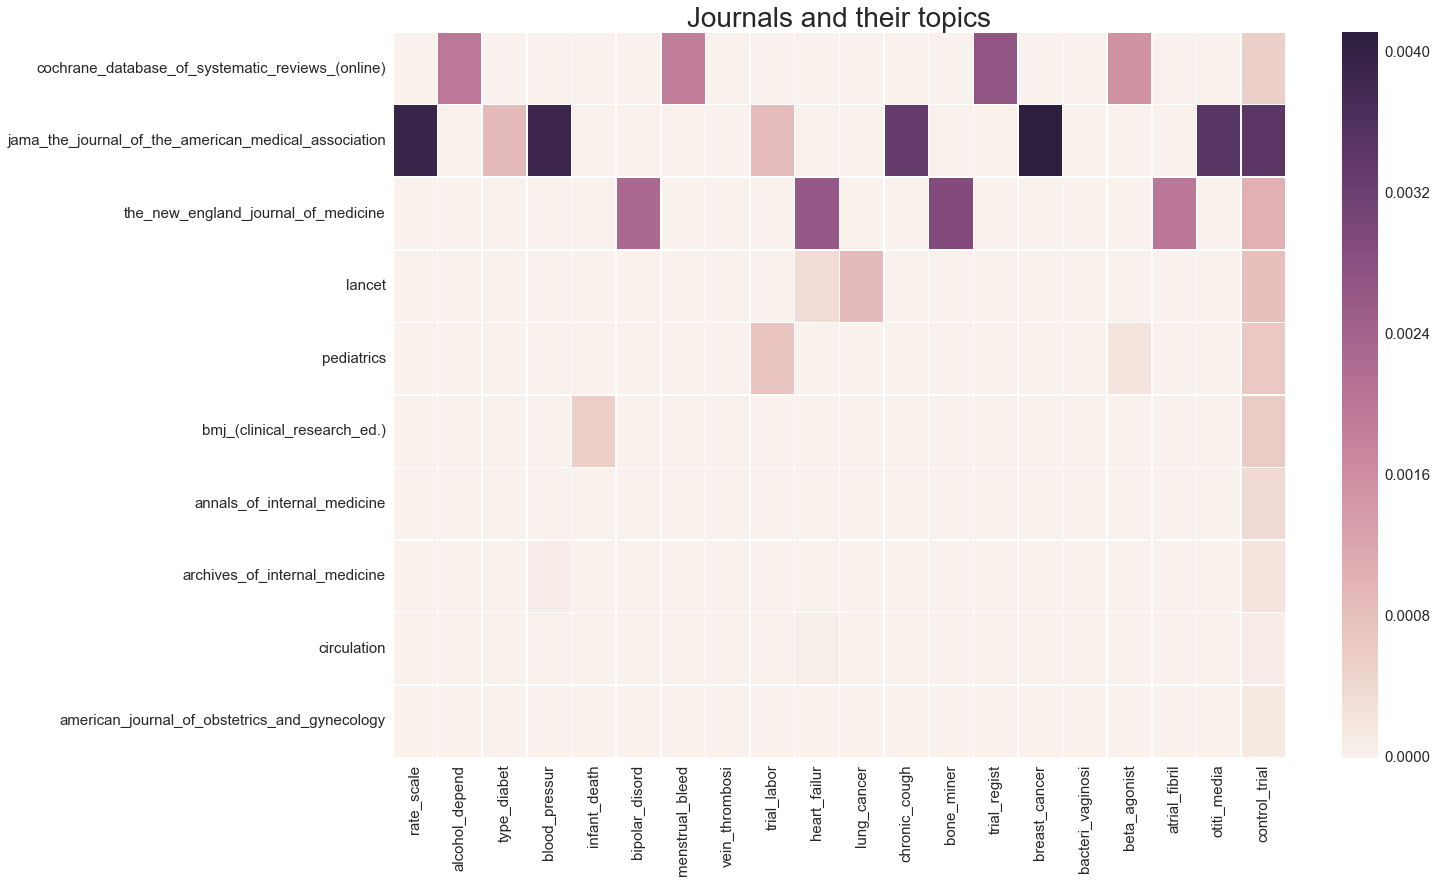

In [73]:
with open("first_task/model/journal_map_myModel.pickle", "r") as f:
    journal_map = pickle.load(f)
    
plt.figure(figsize=(20, 13))
sns.set(font_scale=1.5)
sns.heatmap(journal_map.ix[["_".join(x[0].replace(": ", "").split(" ")) for x in srt_journals], :], 
            xticklabels=alt_topic_names,
            linewidths=.5)
plt.title("Journals and their topics", fontsize=28)
plt.plot()

Next figure shows that all the countries write articles about all the topics.

[]

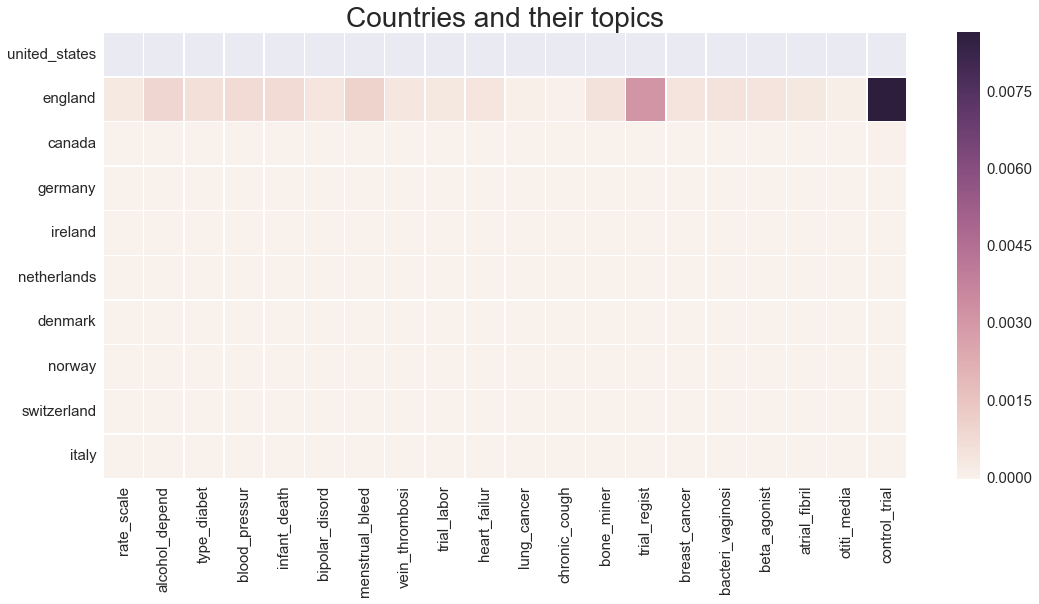

In [43]:
with open("first_task/model/country_map_myModel.pickle", "r") as f:
    country_map = pickle.load(f)
    
plt.figure(figsize = (18, 8))
sns.set(font_scale=1.5)
sns.heatmap(country_map.ix[["_".join(x[0].replace(": ", "").split(" ")) for x in srt_countries], :], 
            xticklabels=alt_topic_names,
            linewidths=.5)
plt.title("Countries and their topics", fontsize=28)
plt.plot()

As I mentioned before there are a lot of possible improvements.

## Second Task

Pipeline: <img src="images/pipeline2.png">

###### Medical Terms Extraction
Dictionary of medical terms was scrapped, using urllib and bs4, from this [site](http://users.ugent.be/~rvdstich/eugloss/EN/lijst.html), also it is possible to use [MeSH database](https://en.wikipedia.org/wiki/Medical_Subject_Headings_(MeSH).
Then I just checked which words from abstracts are present (stemming was applied) in created dictionary.
Let's look at the results.

In [25]:
with open("second_task/medical_terms.pickle", "r") as f:
    medical_terms = pickle.load(f)

with open("second_task/present_medical_terms.pickle", "r") as f:
    present_medical_terms = sorted(list(pickle.load(f)))

print "Number of medical terms in dictionary is", len(medical_terms)
print "Number of medical terms in abstracts is", len(present_medical_terms)
print "First five (by alphabet) terms:", 
for x in present_medical_terms[: 5]: print x + ",",
print "\nLast five (by alphabet) terms:",
for x in present_medical_terms[-5: ]: print x + ",",

Number of medical terms in dictionary is 1816
Number of medical terms in abstracts is 1237
First five (by alphabet) terms: abdomen, abdomin, aberr, abnorm, abort, 
Last five (by alphabet) terms: visual, vital, voluntari, vulvovagin, withdraw,


###### Search for Synonyms
Two lexemes are synonyms 
- if they can be substituted for each other in all situations
- if so they have the same propositional meaning

But there are few (or no) examples of perfect synonymy.
- even if many aspects of meaning are identical
- still may not preserve the acceptability based on notions of politeness, slang, register, genre, etc.

Synonymy is a relation between senses rather than words. So, i will consider distributional word similarity. It is possible everything compute by hands - first compute [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) between words and their contex; then find most similar words, [KDTree](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html) can be used to rapidly look up the nearest neighbors of any point.

But it is more rational to use [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) model and then apply *most_similar("word")* method.

From results we can see that there are only a few true synonyms (e.g. maximum = peak, aerosol = spray, ...) and some releted by sense and most of them related by coocurence or causes (e.g. dyspepsia = insomnia, dose = oral, ...).

Possible improvements:
- get more data
- use topics: same topic in different abstracts -> words from them can be synonyms
- use differnt types of abstracts (objective, methods, results, conclusions, ...) -> scientists can use synonyms in these parts to not to repeat themselves
- build topic models for each type of abstracts -> consider that, e.g. objective and conslussions are about the same thing.
- build topic models for each journal -> maybe terminology a little bit different between them (just a guess)
- use ngrams -> maybe some terms consist of more than one word (Word2Vec can do this)
- also MeSH database provides sysnonyms for terms (just decided to do task more interesting and it takes some time to understand it's structure)

In [66]:
with open("second_task/synonyms.pickle", "r") as f:
    synonyms = pickle.load(f)

for term in sorted(synonyms.items(), key=lambda x: x[0]):
    if term[1] and ("anti" not in term[0]) and ("anti" not in term[1][0]):
        print "{0} = {1}".format(term[0], term[1][0])

accident = hypomania
aerosol = spray
albumin = basal
alert = insult
alopecia = discoid
amenorrhoea = enema
anaesthesia = anal
anal = anaesthesia
analog = visual
angina = ischaemia
anorexia = nausea
anosmia = viral
antacid = intramuscular
antagonist = receptor
atrium = ventricular
aura = tension
auricular = amnesia
barrier = monitor
basal = albumin
benign = parenchyma
block = digit
bradycardia = schizophrenia
bronchial = abdomen
cachexia = cognit
carcinoma = dysplasia
cardiac = cardiovascular
cardiovascular = cardiac
cell = neutrophil
cerebrovascular = manifest
cholesterol = serum
classic = anaesthesia
cognit = cachexia
collagen = block
colon = region
complex = viral
conduct = research
contact = hypomania
correct = phenomenon
cortex = extract
corticosteroid = steroid
cranial = progress
criterion = neural
detect = protect
digit = dorsal
discoid = alopecia
dorsal = digit
dose = oral
dyspareunia = paraplegia
dyspepsia = insomnia
dysplasia = carcinoma
eclampsia = flutter
eczema = delirium
e